In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from datetime import date
import scipy


import tensorflow as tf

import matplotlib as mpl
import os
import plotly.graph_objects as go
from prettytable import PrettyTable

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

### Теоретический план пайплайна

1. Загрузка данных
2. Предобработка
3. Разделение на train и test, формирование батчей
4. Обучение модели 
5. Отрисовка графиков и метрик 
6. Подготовка сабмита

---

### Реализация пайплайна со всеми необходимыми методами

Для работы небходимо загрузить `train.csv` и `process.py`

In [53]:
from process import process as prc
from process import fix_nan
from process import SMAPE, WAPE

In [55]:
class Pipeline:
    modify_list = []
    batch_len = 52
    train_lim = 105
    metrics = {"mse": lambda x,y:((x-y)**2).sum(),
              "wape": WAPE,
              "smape":SMAPE}
    
    def set_path(self, path):
        """
        Загрузка данных.
        :path - локальный путь до файла csv
        """
        self.data_path = path
        self.raw_data = pd.read_csv(path)
        self.non_na_data = self.raw_data

    def process(self, **kwargs):
        """
        Предобаботка датасета.
        :**kwargs - параметры для генерации необходимых фичей
        """
        self.data = self.non_na_data
        self.data['period_start_dt'] = pd.to_datetime(self.data['period_start_dt'])
        self.data = prc(self.data, **kwargs)
        self.data = self.data.set_index('Unnamed: 0')
        self.split()

        self.train = self.train.drop('period_start_dt',axis=1).fillna(0.0)
        self.test = self.test.drop(['demand'], axis=1).fillna(0.0)
        
    def compile_train_ds(self):
        """
        Подготовка батчей для обучения модели для train датасета
        """
        def split(ds, scaler):
            y = ds.demand.values.reshape(-1, 1)
            x = scaler.fit_transform(ds.drop('demand',axis=1))
            #x = ds.drop('demand',axis=1).values
            ts = TimeseriesGenerator(x[:self.train_lim], y[:self.train_lim], 10) 
            return ts, x, y, ds

        def make_ds(dataset):
            g = dataset.groupby(['product_rk','store_location_rk'])
            gg = np.array(g)[:,1]
            scalers = []
            for i in range(gg.shape[0]):
                if gg[i].shape[0] <= 10:
                    continue
                ds = gg[i]
                scalers.append(MinMaxScaler(feature_range=(0, 1)))
                # add_components(ds)
                ds.drop(['product_rk','store_location_rk'], axis=1, inplace=True)
                ds.reset_index(drop=True, inplace=True)
            return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers

        self.train_ds = make_ds(self.train)[0]
        # return self.train

    def compile_test_ds(self):
        """
        Подготовка батчей для обучения модели для test датасета
        """
        def split_test(ds, scaler):
            x = scaler.fit_transform(ds.drop(['product_rk','store_location_rk','period_start_dt', 'Unnamed: 0'],axis=1))
            return x, ds

        def make_ds_test(dataset):
            g = dataset.groupby(['product_rk','store_location_rk'])
            gg = np.array(g)[:,1]
            scalers = []
            for i in range(gg.shape[0]):
                ds = gg[i]
                scalers.append(MinMaxScaler(feature_range=(0, 1)))
                ds.reset_index(inplace=True)
            return [split_test(x, scalers[-1]) for x in gg], scalers

        self.test_ds = make_ds_test(self.test)[0]

    def split(self):
        """
        Разделение датасета на train и test части
        """
        self.train = self.data[~self.data.demand.isna()].copy()
        self.test = self.data[self.data.demand.isna()].copy()
        
    def set_model(self, model, optimizer):
        """
        Сохранение модели и оптимизатора
        :model - модель для обучения
        :optimizer - оптимизатор
        """
        self.model = model
        self.optimizer = optimizer
        self.model.compile(optimizer=self.optimizer, loss='mse')
        
    def fit(self, epochs=5):
        """
        Обучение модели с отрисовкой функции потерь 
        :epochs - количество эпох
        """
        self.hist = []
        # ds = self.compile_train_ds()[0]
        for epoch in range(epochs):   
            for batch in self.train_ds:        
                for series in batch[0]:            
                    self.hist.append(self.model.train_on_batch(series[0], series[1]))

            clear_output() 
            print("Epoch {} of {}".format(epoch + 1, epochs))
            fig = plt.figure(figsize=(20, 7))
            plt.title('Лосс', fontsize=15)
            plt.plot(self.hist)
            plt.show()
                
    def sample(self, k=0, metric=None):
        """
        Демонстрация предсказания модели на заданной паре товар-магазин
        :k - идентификатор пары
        :metric - метрика, по которой посчитать качетсво предсказания
                  для заданной пары
        """
        val = self.train_ds[k][1]
        y = self.train_ds[k][2]
        yhat = [0] * 10
        n = val.shape[0]
        for i in range(10, n):
            yhat.append(self.model.predict(val[i-10:i].reshape(1, 10, -1))[0][-1][0])
            if yhat[-1] < 0:
                yhat[-1] = 0

        plt.figure(figsize=(12, 6))
        plt.plot(y, label='true')
        plt.plot(yhat,label='pred')
        # plt.vlines(self.train_lim, 0, 1000, color='red')
        plt.ylim(0, y.max()+100)
        plt.legend()

        if metric is not None:
            print(f'metric {metric} = {self.metrics[metric](yhat, y.squeeze())}')
        plt.show()

    def build_submit(self):
        """
        Подготовка сабмита для kaggle
        """
        for ts in self.test_ds:
            x = ts[0]
            ds = ts[1]
            y_hat = []
            product = list(ds['product_rk'])[0]
            store = list(ds['store_location_rk'])[0]
            train_last = self.train[(self.train.product_rk == product) &
                              (self.train.store_location_rk == store)][-10:].\
                              drop(['product_rk','store_location_rk', 'demand'], axis=1).values
            x = np.vstack((train_last, x))
            for i in range(10, x.shape[0]):
                id = ds.loc[i-10,'Unnamed: 0']
                pred = model.predict(x[i-10:i].reshape(1, 10, -1))[0][-1]
                if pred < 0:
                    self.test.loc[id, 'predicted'] = 0
                else:
                    self.test.loc[id, 'predicted'] = pred

        self.prediction = self.test[['predicted']].copy()
        return self.prediction


In [66]:
# data_path = "../data"+'/train.csv'
data_path = 'train.csv'

In [67]:
ppl = Pipeline()

Загрузим данные

In [68]:
ppl.set_path(data_path)

Предобработаем данные и посмотрим на полученные признаки

In [69]:
ppl.process(tw=True, lagged_by_all_products=True, lagged_by_all_stores=True)

In [70]:
ppl.data.head()

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_mean,demand_lag7_wdw7_median,demand_lag7_wdw7_pctl10,demand_lag7_wdw7_pctl90,demand_lag14_wdw7_mean,demand_lag14_wdw7_median,demand_lag14_wdw7_pctl10,demand_lag14_wdw7_pctl90,demand_lag21_wdw7_mean,demand_lag21_wdw7_median,demand_lag21_wdw7_pctl10,demand_lag21_wdw7_pctl90,demand_lag28_wdw7_mean,demand_lag28_wdw7_median,demand_lag28_wdw7_pctl10,demand_lag28_wdw7_pctl90,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_median,all_stores_demand_lag28_wdw7_pctl10,all_stores_demand_lag28_wdw7_pctl90,...,store_location_rk_517,store_location_rk_525,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,40369,309,2016-12-19,29.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40370,309,2016-12-19,64.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.505855,3.5,1.5,5.416393,3.642857,3.5,1.5,5.9,3.142857,3.0,3.0,3.5,4.785714,5.0,2.7,7.2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40372,309,2016-12-19,32.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.928571,10.5,5.1,11.400000,9.857143,10.5,4.8,14.3,9.928571,10.0,9.3,10.5,10.571429,11.5,6.0,14.8,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40373,309,2016-12-19,10.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.785714,6.0,3.3,7.900000,4.642857,5.0,2.7,6.0,5.142857,5.0,4.8,5.6,5.428571,6.0,3.0,7.1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,46272,309,2016-12-19,15.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.857143,4.5,2.4,5.000000,3.785714,4.5,1.8,5.0,3.714286,4.0,3.0,4.0,3.500000,4.0,1.8,5.2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Разобьем датасет на батчи для обучения модели

In [72]:
ds = ppl.compile_train_ds()

Определим саму модель

In [79]:
"""
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(10, 157)),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
    tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(10, 157)),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
    tf.keras.layers.LSTM(32, return_sequences=True),#, input_shape=(None,157), return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),#, return_sequences=True),
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(5, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()
"""

"\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(10, 157)),\n    tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),\n    tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(10, 157)),\n    tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),\n    tf.keras.layers.LSTM(32, return_sequences=True),#, input_shape=(None,157), return_sequences=True),\n    tf.keras.layers.LSTM(32, return_sequences=True),#, return_sequences=True),\n    tf.keras.layers.Dense(10, activation='elu'),\n    tf.keras.layers.Dense(5, activation='elu'),\n    tf.keras.layers.Dense(1, activation='linear')\n])\n\noptimizer = tf.keras.optimizers.Adam()\n"

In [ ]:
"""
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),#, input_shape=(None,157), return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),#, return_sequences=True),
    tf.keras.layers.Dense(40, activation='elu'),
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()
"""

In [ ]:
"""
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),#, input_shape=(None,157), return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),#, return_sequences=True),
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(50, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()
"""

In [ ]:
"""
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),#, input_shape=(None,157), return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),#, return_sequences=True),
    tf.keras.layers.Dense(100, activation='elu'),
    tf.keras.layers.Dense(50, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()
"""

In [ ]:
"""
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),#, input_shape=(None,157), return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),#, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),#, return_sequences=True),
    tf.keras.layers.Dense(50, activation='elu'),
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()
"""

In [73]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(10, 157)),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(10, 157)),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
    tf.keras.layers.GRU(16, return_sequences=True),#, input_shape=(None,157), return_sequences=True),
    tf.keras.layers.GRU(16, return_sequences=True),#, return_sequences=True),
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(5, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()

In [74]:
ppl.set_model(model, optimizer)


Обучим модель с количеством эпох, равным 300

Epoch 300 of 300


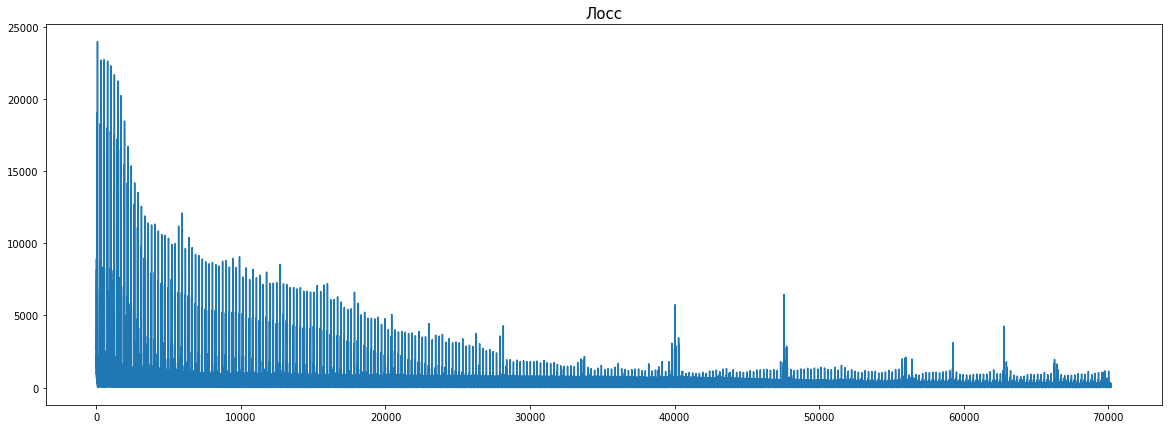

In [75]:
ppl.fit(300)

Посмотрим на предсказания модели на примере нескольких пар товар/магазин

metric wape = [0.47240672732088745]


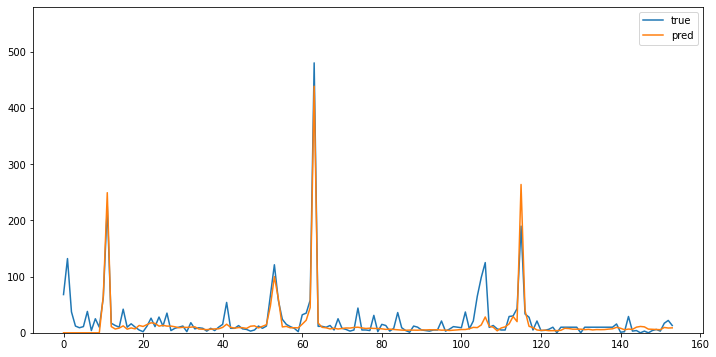

In [76]:
ppl.sample(7, "wape")

metric wape = [0.586045262088642]


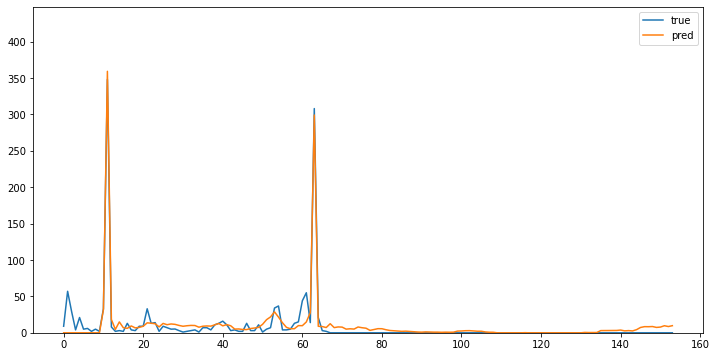

In [77]:
ppl.sample(8, "wape")

metric wape = [0.6120286302597348]


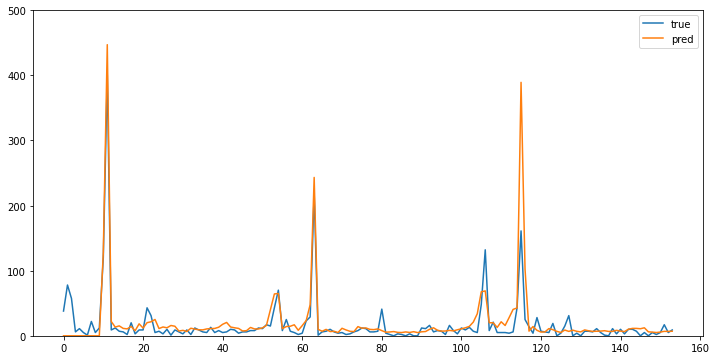

In [78]:
ppl.sample(1, "wape")

In [ ]:
ppl.compile_test_ds()

Подготовим сабмит

In [ ]:
ppl.build_submit()

,predicted
Unnamed: 0,
908,0.527339
909,0.423147
910,0.423147
911,0.423147
912,1.102532
...,...
35537,0.552540
35538,0.512058
35539,0.543729
